In [1]:
import numpy as np
import tensorflow as tf
import math
import cv2
import matplotlib.pyplot as plt
import time
import random
from pylab import legend
from utils import *

In [2]:
def seg_deconv(in_l,k_s,i_s,edge,edge_n,in_n,out_n,name,is_train):
    w_edge_1,b_edge_1=make_wei(name+'_1',k_s,in_n+edge_n,in_n)
    w_edge_2,b_edge_2=make_wei(name+'_2',k_s,in_n,in_n)
    w_edge_3,b_edge_3=make_wei(name+'_3',k_s,in_n,out_n)

    edge_1=tf.image.resize_images(in_l,[math.ceil(i_s),math.ceil(i_s)],method=tf.image.ResizeMethod.BILINEAR)
    edge_2=tf.concat([edge,edge_1],3)
    edge_3=n_relu(tf.nn.conv2d(edge_2,w_edge_1, strides=[1,1,1,1], padding= 'SAME')+b_edge_1)
    edge_4=n_relu(tf.nn.conv2d(edge_3,w_edge_2, strides=[1,1,1,1], padding= 'SAME')+b_edge_2)
    edge_5=n_relu(tf.nn.conv2d(edge_4,w_edge_3, strides=[1,1,1,1], padding= 'SAME')+b_edge_3)

    return edge_5

In [3]:
def dep_deconv(in_l,k_s,i_s,edge,edge_n,in_n,out_n,name,is_train):
    w_edge_1,b_edge_1=make_wei(name+'_1',k_s,in_n+edge_n,in_n)
    w_edge_2,b_edge_2=make_wei(name+'_2',k_s,in_n,in_n)
    w_edge_3,b_edge_3=make_wei(name+'_3',k_s,in_n,out_n)

    edge_1=tf.image.resize_images(in_l,[math.ceil(i_s),math.ceil(i_s)],method=tf.image.ResizeMethod.BILINEAR)
    edge_2=tf.concat([edge,edge_1],3)
    edge_3=bn_relu(tf.nn.conv2d(edge_2,w_edge_1, strides=[1,1,1,1], padding= 'SAME')+b_edge_1)
    edge_4=bn_relu(tf.nn.conv2d(edge_3,w_edge_2, strides=[1,1,1,1], padding= 'SAME')+b_edge_2)
    edge_5=bn_relu(tf.nn.conv2d(edge_4,w_edge_3, strides=[1,1,1,1], padding= 'SAME')+b_edge_3)

    return edge_5

In [4]:
def make_norm_at(in_layer,k_s,in_n,out_n,l_n,name,is_train):
    for i in range(l_n):
        if i==0:
            w,b=make_wei(name+'_'+str(i+1),k_s,in_n,out_n)
            in_layer_1=n_relu(tf.nn.atrous_conv2d(in_layer,w, rate=2, padding= 'SAME')+b)
        else:
            w,b=make_wei(name+'_'+str(i+1),k_s,out_n*2,out_n)
            in_layer_1=n_relu(tf.nn.atrous_conv2d(in_layer_1,w, rate=2, padding= 'SAME')+b)
    return in_layer_1

In [5]:
def make_norm_conv(in_layer,k_s,in_n,out_n,l_n,name,is_train):
    for i in range(l_n):
        if i==0:
            w,b=make_wei(name+'_'+str(i+1),k_s,in_n,out_n)
            in_layer_1=n_relu(tf.nn.conv2d(in_layer,w, strides=[1,1,1,1], padding= 'SAME')+b)
        else:
            w,b=make_wei(name+'_'+str(i+1),k_s,out_n*2,out_n)
            in_layer_1=n_relu(tf.nn.conv2d(in_layer_1,w, strides=[1,1,1,1], padding= 'SAME')+b)
    return in_layer_1

In [6]:
def make_dep_norm_conv(in_layer,k_s,in_n,out_n,l_n,name,is_train):
    for i in range(l_n):
        if i==0:
            w,b=make_wei(name+'_'+str(i+1),k_s,in_n,out_n)
            in_layer_1=d_norm_relu(tf.nn.conv2d(in_layer,w, strides=[1,1,1,1], padding= 'SAME')+b)
        else:
            w,b=make_wei(name+'_'+str(i+1),k_s,out_n*2,out_n)
            in_layer_1=d_norm_relu(tf.nn.conv2d(in_layer_1,w, strides=[1,1,1,1], padding= 'SAME')+b)
    return in_layer_1

In [7]:
def make_conv(in_layer,k_s,in_n,out_n,l_n,name,is_train):
    for i in range(l_n):
        if i==0:
            w,b=make_wei(name+'_'+str(i+1),k_s,in_n,out_n)
            in_layer_1=relu(tf.nn.conv2d(in_layer,w, strides=[1,1,1,1], padding= 'SAME')+b)
        else:
            w,b=make_wei(name+'_'+str(i+1),k_s,out_n*2,out_n)
            in_layer_1=relu(tf.nn.conv2d(in_layer_1,w, strides=[1,1,1,1], padding= 'SAME')+b)
    return in_layer_1

In [8]:
def relu(layer):  

    return tf.concat([tf.nn.relu(layer),tf.nn.sigmoid(layer)],3)

In [9]:
def n_relu(layer):  
    mean,var=tf.nn.moments(layer,[1,2])
    num=tf.to_int32(mean.shape[1])
    mean_1=tf.reshape(mean,[-1,1,1,num])
    var_1=tf.reshape(var,[-1,1,1,num])
    layer_1=(layer-mean_1)/var_1
    return tf.concat([tf.nn.relu(layer_1),tf.nn.sigmoid(layer_1)],3)

In [10]:
def d_norm_relu(layer):  
    mean,var=tf.nn.moments(layer,[1,2])
    num=tf.to_int32(mean.shape[1])
    mean_1=tf.reshape(mean,[-1,1,1,num])
    var_1=tf.reshape(var,[-1,1,1,num])
    layer_1=(layer-mean_1)/var_1
    return tf.concat([tf.nn.sigmoid(layer_1),tf.nn.sigmoid((-1.0)*layer_1)],3)

In [11]:
def norm_fc(layer):  
    mean,var=tf.nn.moments(layer,[1])
    mean_1=tf.reshape(mean,[-1,1])
    var_1=tf.reshape(var,[-1,1])
    layer_1=(layer-mean_1)/var_1
    return layer_1

In [12]:
def norm_relu(layer):  
    mean,var=tf.nn.moments(layer,[1,2])
    num=tf.to_int32(mean.shape[1])
    mean_1=tf.reshape(mean,[-1,1,1,num])
    var_1=tf.reshape(var,[-1,1,1,num])
    layer_1=(layer-mean_1)/var_1
    return layer_1

In [13]:
def img_resize(img,s):
    x=np.minimum(img.shape[0],img.shape[1])
    re_img=img[img.shape[0]-x:img.shape[0],img.shape[1]-x:img.shape[1]]
    im=cv2.resize(re_img, (s,s), interpolation=cv2.INTER_NEAREST)
    return im

In [14]:
def dep_resize(img,s):
    x=np.minimum(img.shape[0],img.shape[1])
    re_img=img[img.shape[0]-x:img.shape[0],img.shape[1]-x:img.shape[1]]
    im=cv2.resize(re_img, (s,s), interpolation=cv2.INTER_LINEAR)
    return im

In [15]:
def make_fc(name,in_l_num,out_l_num,in_layer):
    w= tf.get_variable('w_'+name, shape=[in_l_num,out_l_num], initializer=tf.contrib.layers.xavier_initializer())
    b=tf.get_variable('b_'+name, shape=[out_l_num], initializer=tf.contrib.layers.xavier_initializer())
    
    return tf.matmul(in_layer,w)+b

In [16]:
def get_crf(img,seg_img,dep_img,deri,num):
    s_img=tf.square(tf.nn.atrous_conv2d(seg_img, deri,rate=num, padding='VALID'))
    
    im=tf.exp(-1*0.1*((7-num)/5)*tf.square(tf.nn.atrous_conv2d(img, deri,rate=num, padding='VALID')))
    
    s_i_crf=tf.multiply(s_img,im)
    s_d_crf=tf.multiply((1-s_img),(1-im))
    s_sum=(tf.reduce_mean(tf.reduce_sum(s_i_crf,1))*0.5)+(tf.reduce_mean(tf.reduce_sum(s_d_crf,1))*0.5)
    
    d_img=tf.exp(-1*0.1*((7-num)/5)*tf.square(tf.nn.atrous_conv2d(dep_img, deri,rate=num, padding='VALID')))
    
    d_i_crf=tf.multiply(s_img,d_img)
    d_d_crf=tf.multiply((1-s_img),(1-d_img))
    d_sum=(tf.reduce_mean(tf.reduce_sum(d_i_crf,1))*0.5)+(tf.reduce_mean(tf.reduce_sum(d_d_crf,1))*0.5)
    
    crf_sum=(s_sum*0.4)+(d_sum*0.6)
    return crf_sum

In [17]:
def seg_deri(seg_img,dep_img,img,ch,s_d_1,s_d_2,s_d_3,s_d_4):
    s_deri_1 = tf.reshape(s_d_1, [3, 3, 1, 1])
    s_deri_2 = tf.reshape(s_d_2, [3, 3, 1, 1])
    s_deri_3 = tf.reshape(s_d_3, [3, 3, 1, 1])
    s_deri_4 = tf.reshape(s_d_4, [3, 3, 1, 1])
    seg_crf=0
    
    for n in range(ch):
        seg_deri=tf.slice(seg_img,[0,0,0,n],[-1,-1,-1,1])
        for i in range(2):
            seg_crf_1=get_crf(img,seg_deri,dep_img,s_deri_1,i+1)
            seg_crf_2=get_crf(img,seg_deri,dep_img,s_deri_2,i+1)
            seg_crf_3=get_crf(img,seg_deri,dep_img,s_deri_3,i+1)
            seg_crf_4=get_crf(img,seg_deri,dep_img,s_deri_4,i+1)
            seg_crf+=(seg_crf_1+seg_crf_2+seg_crf_3+seg_crf_4)/4.0
    return seg_crf/ch

In [18]:
def seg_dep(seg_img,dep_img,seg_ch,dep_ch):
    dep_1=tf.slice(dep_img,[0,0,0,0],[-1,-1,-1,1])
    dep_2=tf.slice(dep_img,[0,0,0,1],[-1,-1,-1,1])
    seg_dep_img=tf.concat([seg_img*dep_1,seg_img*dep_2],3)
    return seg_dep_img

In [19]:
# def seg_deri(seg_img,dep_img,img,ch):
#     s_deri_1_1 = tf.reshape(seg_deri_1, [3, 3, 1, 1])
#     s_deri_2_1 = tf.reshape(seg_deri_2, [3, 3, 1, 1])

#     seg_crf_sum=0
#     for n in range(ch):
#         seg_deri=tf.slice(seg_img,[0,0,0,n],[-1,-1,-1,1])
#         for i in range(2):
#             seg_crf_1=get_crf(img,seg_deri,dep_img,s_deri_1_1,i+1)
#             seg_crf_2=get_crf(img,seg_deri,dep_img,s_deri_1_2,i+1)
#             seg_crf=(seg_crf_1+seg_crf_2)/2.0
#             seg_crf_sum+=seg_crf
#     return seg_crf_sum/ch

In [20]:
# def seg_deri(seg_img,dep_img,img,ch):
#     s_deri_1 = tf.reshape(seg_deri_1, [3, 3, 1, 1])
#     s_deri_2 = tf.reshape(seg_deri_2, [3, 3, 1, 1])
#     s_deri_3 = tf.reshape(seg_deri_3, [3, 3, 1, 1])
#     s_deri_4 = tf.reshape(seg_deri_4, [3, 3, 1, 1])

#     seg_crf=0
#     for n in range(ch):
#         seg_deri=tf.slice(seg_img,[0,0,0,n],[-1,-1,-1,1])
#         for i in range(2):
#             seg_crf_1=get_crf(img,seg_deri,dep_img,s_deri_1,i+1)
#             seg_crf_2=get_crf(img,seg_deri,dep_img,s_deri_2,i+1)
#             seg_crf_3=get_crf(img,seg_deri,dep_img,s_deri_3,i+1)
#             seg_crf_4=get_crf(img,seg_deri,dep_img,s_deri_4,i+1)
#             seg_crf+=(seg_crf_1+seg_crf_2+seg_crf_3+seg_crf_4)/4.0
#     return seg_crf/ch

In [21]:
img_size=224
train_num=10000
test_num=3000

In [22]:
# for i in range(5285):
#     cv2.imwrite('img_data/train_image/img-'+str(i+1+5285).zfill(6)+'.jpg',img_resize(cv2.imread('data/train_images/img-'+str(i+1).zfill(6)+'.jpg'),img_size))
# for i in range(5285):
#     cv2.imwrite('img_data/train_label/img-'+str(i+1+5285).zfill(6)+'.png',img_resize(cv2.imread('data/train_labels/img13labels-'+str(i+1).zfill(6)+'.png',0),img_size))
# for i in range(5285):
#     cv2.imwrite('img_data/train_depth/img-'+str(i+1+5285).zfill(6)+'.png',dep_resize(cv2.imread('data/train_depth/'+str(i+1)+'.png',0),img_size)) 
    
# for i in range(5050):
#     cv2.imwrite('img_data/test_image/img-'+str(i+1+5050).zfill(6)+'.jpg',img_resize(cv2.imread('data/test_images/img-'+str(i+1).zfill(6)+'.jpg'),img_size))
# for i in range(5050):
#     cv2.imwrite('img_data/test_label/img-'+str(i+1+5050).zfill(6)+'.png',img_resize(cv2.imread('data/test_labels/img13labels-'+str(i+1).zfill(6)+'.png',0),img_size))
# for i in range(5050):
#     cv2.imwrite('img_data/test_depth/img-'+str(i+1+5050).zfill(6)+'.png',dep_resize(cv2.imread('data/test_depth/'+str(i+1)+'.png',0),img_size))

In [23]:
train_image=[im_resize(cv2.imread('E:/image/img_data/train_image/img-'+str(i+1).zfill(6)+'.jpg'),img_size) for i in range(train_num)]#5285

In [24]:
train_label=[im_resize(cv2.imread('E:/image/img_data/train_label/img-'+str(i+1).zfill(6)+'.png',0),img_size) for i in range(train_num)]#5285

In [25]:
train_depth=[depth_resize(cv2.imread('E:/image/img_data/train_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size) for i in range(train_num)]#5285

In [26]:
test_image=[im_resize(cv2.imread('E:/image/img_data/test_image/img-'+str(i+1).zfill(6)+'.jpg'),img_size) for i in range(test_num)]#5050

In [27]:
test_label=[im_resize(cv2.imread('E:/image/img_data/test_label/img-'+str(i+1).zfill(6)+'.png',0),img_size) for i in range(test_num)]

In [28]:
test_depth=[depth_resize(cv2.imread('E:/image/img_data/test_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size) for i in range(test_num)]#5285

In [29]:
h=img_size
w=img_size
c=14

In [30]:
print(h,w,c)

224 224 14


In [31]:
version='16'

In [32]:
graph_x=depth_resize(cv2.imread('E:/image/img_data/train_depth/img-000001.png',0),img_size)[10,:]
graph_y=depth_resize(cv2.imread('E:/image/img_data/train_depth/img-000001.png',0),img_size)[:,10]

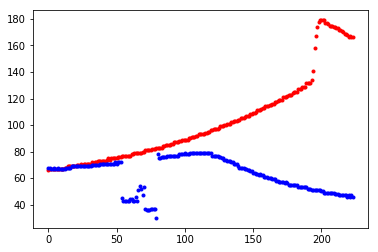

In [33]:
plt.plot(graph_x,'r.')
plt.plot(graph_y,'b.')
plt.show()

In [34]:
from scipy import ndimage
k1 = np.array([[1,0,-1]])
k2 = np.array([[-1,0,1]])
graph_x_1=ndimage.convolve(np.reshape(depth_resize(cv2.imread('E:/image/img_data/train_depth/img-000001.png',0),img_size),(h,w)),k1, mode='constant', cval=0.0)[10,:]
graph_y_1=ndimage.convolve(np.reshape(depth_resize(cv2.imread('E:/image/img_data/train_depth/img-000001.png',0),img_size),(h,w)),k2, mode='constant', cval=0.0)[10,:]

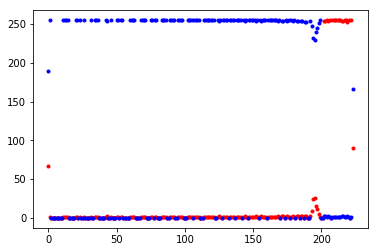

In [35]:
plt.plot(graph_x_1,'r.')
plt.plot(graph_y_1,'b.')
plt.show()

In [22]:
for i in range(train_num):
    plt.imsave('seg_out'+version+'/output_img-'+str(i+1).zfill(6)+'_st.jpg',im_resize(cv2.imread('E:/image/img_data/train_label/img-'+str(i+1).zfill(6)+'.png',0),img_size))
for i in range(test_num):
    plt.imsave('seg_out'+version+'/test_image/test_img-'+str(i+1).zfill(6)+'_st.png',im_resize(cv2.imread('E:/image/img_data/test_label/img-'+str(i+1).zfill(6)+'.png',0),img_size))
# for i in range(train_num):
#     plt.imsave('seg_out'+version+'/output_img-'+str(i+1).zfill(6)+'_dt.jpg',dep_resize(cv2.imread('E:/image/img_data/train_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size))
# for i in range(test_num):
#     plt.imsave('seg_out'+version+'/test_image/test_img-'+str(i+1).zfill(6)+'_dt.png',dep_resize(cv2.imread('E:/image/img_data/test_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size))

In [36]:
training_epochs=400
tf.reset_default_graph()
x=tf.placeholder(tf.float32,[None,h,w,3]) 
s=tf.placeholder(tf.float32, [None,h,w])
d=tf.placeholder(tf.float32, [None,h,w,1])
keep_prob=tf.placeholder(tf.float32)
train_type=tf.placeholder(tf.bool)
global_step = tf.placeholder(tf.float32)
seg_deri_1=tf.constant([[0,0,0],[0,1,-1],[0,0,0]], tf.float32)
seg_deri_2=tf.constant([[0,-1,0],[0,1,0],[0,0,0]], tf.float32)
seg_deri_3=tf.constant([[0,0,-1],[0,1,0],[0,0,0]], tf.float32)
seg_deri_4=tf.constant([[0,0,0],[0,1,0],[0,0,-1]], tf.float32)

In [37]:
l_d_1_3=make_norm_conv(d,3,1,1,2,'d_1',train_type)

In [38]:
l_c_1_3=make_norm_conv(x,3,3,16,2,'c_1',train_type)
l_c_d_1=seg_dep(l_c_1_3,l_d_1_3,32,2)
l_c_1=tf.nn.max_pool(l_c_d_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
l_c_1=tf.layers.dropout(l_c_1,rate=keep_prob)

l_c_2_3=make_norm_conv(l_c_1,3,64,64,2,'c_2',train_type)
l_c_2=tf.nn.max_pool(l_c_2_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
l_c_2=tf.layers.dropout(l_c_2,rate=keep_prob)

l_c_3_3=make_norm_conv(l_c_2,3,128,128,3,'c_3',train_type)
l_c_3=tf.layers.dropout(l_c_3_3,rate=keep_prob)

l_c_4_3=make_norm_conv(l_c_3,3,256,256,3,'c_4',train_type)
l_c_4=tf.layers.dropout(l_c_4_3,rate=keep_prob)

In [39]:
print(l_c_1)
print(l_c_2)
print(l_c_3)
print(l_c_4)

Tensor("dropout/Identity:0", shape=(?, 112, 112, 64), dtype=float32)
Tensor("dropout_2/Identity:0", shape=(?, 56, 56, 128), dtype=float32)
Tensor("dropout_3/Identity:0", shape=(?, 56, 56, 256), dtype=float32)
Tensor("dropout_4/Identity:0", shape=(?, 56, 56, 512), dtype=float32)


In [40]:
l_c_3_a=make_norm_conv(tf.concat([l_c_3_3,l_c_4_3],3),3,512+256,32,3,'c_3_a', train_type)
l_c_3_a=tf.layers.dropout(l_c_3_a,rate=keep_prob)

l_c_2_a=make_norm_conv(l_c_2_3,3,128,32,3,'c_2_a', train_type)
l_c_2_a=tf.layers.dropout(l_c_2_a,rate=keep_prob)

l_c_1_a=make_norm_conv(l_c_1_3,5,32,32,3,'c_1_a', train_type)
l_c_1_a=tf.layers.dropout(l_c_1_a,rate=keep_prob)

In [41]:
l_seg_4_s=tf.concat([l_c_4,l_c_3_a],3)
l_seg_3=make_norm_conv(l_seg_4_s,3,512+64,256,2,'seg_3',train_type)
l_seg_3=tf.layers.dropout(l_seg_3,rate=keep_prob)

l_seg_3_s=tf.image.resize_images(l_seg_3,[math.ceil(h/2),math.ceil(h/2)],method=tf.image.ResizeMethod.BILINEAR)
l_seg_3_s=tf.concat([l_seg_3_s,l_c_2_a],3)
l_seg_2=make_norm_conv(l_seg_3_s,3,512+64,128,2,'seg_2',train_type)


l_seg_2_s=tf.image.resize_images(l_seg_2,[math.ceil(h),math.ceil(h)],method=tf.image.ResizeMethod.BILINEAR)
l_seg_2_s=tf.concat([l_seg_2_s,l_c_1_a],3)
l_seg_1=make_norm_conv(l_seg_2_s,3,256+64,128,3,'seg_1',train_type)

l_seg_1_s=seg_dep(l_seg_1,l_d_1_3,128,2)

In [43]:
l_seg_0=make_norm_conv(l_seg_1_s,1,512,64,1,'seg_0',train_type)

In [44]:
w_seg,b_seg=make_wei("seg",1,128,c)

In [45]:
l_seg=tf.nn.conv2d(l_seg_0,w_seg, strides=[1,1,1,1], padding= 'SAME')+b_seg

In [46]:
s_one=tf.one_hot(tf.to_int64(s),c)

In [47]:
l_seg_sig=tf.nn.sigmoid(l_seg)
l_seg_avg_3=tf.nn.avg_pool(l_seg_sig, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
l_label_avg_3=tf.nn.avg_pool(s_one, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')

l_label=(s_one*0.6)+(l_label_avg_3*0.4)
l_seg_last=(l_seg_sig*0.6)+(l_seg_avg_3*0.4)

In [48]:
s_image_1=tf.argmax(l_seg_last,3)

In [49]:
seg_one_hot=tf.one_hot(s_image_1,c)

flat_s=tf.reshape(s_one,[-1,c])
flat_output=tf.reshape(seg_one_hot,[-1,c])

inter,label,union=acc(flat_output,flat_s)

In [50]:
# seg_conf=seg_one_hot-tf.multiply(seg_one_hot,s_one)
# s_conf_img=tf.argmax(tf.multiply(seg_conf,tf.nn.softmax(l_seg)),3)

In [51]:
seg_cost=tf.nn.softmax_cross_entropy_with_logits(logits=l_seg,labels=l_label)
seg_cost=tf.reshape(seg_cost,[-1,h*w])
seg_cost=tf.reduce_mean(seg_cost,1)
seg_cost=tf.reduce_mean(seg_cost)

In [52]:
l_fc_1=tf.nn.max_pool(l_c_4, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')

In [53]:
l_fc_2=tf.reshape(l_fc_1,[-1,14*14*512])

In [54]:
l_fc_3 = norm_fc(make_fc('fc_2',14*14*512,512,l_fc_2))

In [55]:
l_fc_4 = norm_fc(make_fc('fc_3',512,256,l_fc_3))
l_fc_5 = make_fc('fc_4',256,c,l_fc_4)

In [56]:
s_pro=tf.reshape(seg_one_hot,[-1,h*w,c])
s_pro=tf.div(tf.reduce_sum(s_pro,1),(h*w))

seg_pro=tf.reshape(s_pro,[-1,c])+0.0001
fc_soft=tf.nn.softmax(l_fc_5)+0.0001
fc_cost=tf.reduce_mean(tf.reduce_sum(tf.multiply(fc_soft,tf.log(tf.div(fc_soft,seg_pro))),1))

In [57]:
# fc_cost=tf.nn.sigmoid_cross_entropy_with_logits(logits=l_fc_2,labels=seg_pro)
# fc_cost=tf.reduce_mean(fc_cost,1)
# fc_cost=tf.reduce_mean(fc_cost)

In [58]:
gray=tf.image.rgb_to_grayscale(x)
crf_cost=seg_deri(l_seg_sig,d,gray,c,seg_deri_1,seg_deri_2,seg_deri_3,seg_deri_4)

In [59]:
# seg_cost=seg_cost_1+seg_cost_2+(seg_cost_3*0.6)
# cost=(seg_cost_1)+(seg_cost_2*0.8)+tf.square(s_x-fc_x)*0.1
cost=(seg_cost*0.6)+(fc_cost*0.3)+(crf_cost*0.1)

In [60]:
starter_learning_rate = 0.0001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,10, 0.9, staircase=True)
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [ ]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver=tf.train.Saver()
# saver.restore(sess,"seg_out"+version+"/seg_model.ckpt")
print("Learning start")

for epoch in range(training_epochs):
    a=0
    batch_size=2
    total_batch = math.ceil(train_num/batch_size)
    start=time.time()
    avg_t_cost=0
    avg_s_cost=0

    
    avg_inter=np.zeros((c))
    avg_gt=np.zeros((c))
    avg_union=np.zeros((c))

    

    for i in range(total_batch):
        if a+batch_size<train_num:
            batch_xs=train_image[a:a+batch_size]
            batch_ys=train_label[a:a+batch_size]
            batch_ds=train_depth[a:a+batch_size]

            feed_dict={x:batch_xs, s:batch_ys, d:batch_ds, keep_prob:0.8, train_type:True, global_step:epoch}
            rate,s_img_1,s_img_2,t_c,s_c,_=sess.run([learning_rate,s_image_1,seg_one_hot,cost,seg_cost,optimizer], feed_dict=feed_dict)
            in_1,gt_1,un_1=sess.run([inter,label,union], feed_dict=feed_dict)
            for j in range(batch_size):
                plt.imsave('seg_out'+version+'/output_img-'+str(a+j+1).zfill(6)+'.png',s_img_1[j])
                for q in range(c):
                    plt.imsave('seg_out'+version+'/conf_map/class_img_'+str(a+j+1)+'_'+str(q).zfill(2)+'.png',s_img_2[j,:,:,q])
                
            a=a+batch_size
            avg_s_cost+=s_c
            avg_t_cost+=t_c
            
            avg_inter+=in_1
            avg_gt+=gt_1
            avg_union+=un_1


    print("epoch : ", epoch)
    print("cost : ", '{:.5f}'.format(avg_t_cost/total_batch),"seg_2_cost : ", '{:.5f}'.format(avg_s_cost/total_batch))
    print("\n")

    s_iou,s_mean,m_iou,m_mean=iou_mean(avg_inter,avg_union,avg_gt,c)

    
    saver.save(sess, "seg_out"+version+"/seg_model.ckpt")
    end=time.time()
    print(end-start)
    print("\n")
    t_start=time.time()
    if epoch%2==0:
        test_a=0
        test_batch_size=2
        test_total_batch = math.ceil(test_num/test_batch_size)
        
        test_avg_t_cost=0
        test_avg_s_cost=0

        
        test_avg_inter=np.zeros((c))
        test_avg_gt=np.zeros((c))
        test_avg_union=np.zeros((c))




        for i in range(test_total_batch):
            if test_a+test_batch_size<test_num:
                test_batch_xs=test_image[test_a:test_a+test_batch_size]
                test_batch_ys=test_label[test_a:test_a+test_batch_size]
                test_batch_ds=test_depth[test_a:test_a+test_batch_size]
                
                
                test_feed_dict={x:test_batch_xs, s:test_batch_ys, d:test_batch_ds, keep_prob:1.0,train_type:False,global_step:epoch}
                t_s_img_1,t_s_c,t_t_c=sess.run([s_image_1, seg_cost,cost], feed_dict=test_feed_dict)
                t_in_1,t_gt_1,t_un_1=sess.run([inter,label,union], feed_dict=feed_dict)
        
                for k in range(test_batch_size):
                    plt.imsave('seg_out'+version+'/test_image/test_img-'+str(test_a+k+1).zfill(6)+'.png',t_s_img_1[k])


                test_a=test_a+test_batch_size

                test_avg_s_cost+=t_s_c

                test_avg_t_cost+=t_t_c



                test_avg_inter+=t_in_1
                test_avg_gt+=t_gt_1
                test_avg_union+=t_un_1

            
        print("\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\ test_network \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
        print("cost : ",'{:.5f}'.format(test_avg_t_cost/test_total_batch), "seg_2_cost : ",'{:.5f}'.format(test_avg_s_cost/test_total_batch))
        test_s_iou,test_s_mean,test_m_iou,test_m_mean=iou_mean(test_avg_inter,test_avg_union,test_avg_gt,c)

        t_end=time.time()
        print(t_end-t_start)

        print("\n")
        
        if epoch%6==0:
            print("train_iou")
            print(np.round(s_iou,3))
            print("train_mean")
            print(np.round(s_mean,3))
            print("test_iou")
            print(np.round(test_s_iou,3))
            print("test_mean")
            print(np.round(test_s_mean,3))
            print("\n")
            feed_dict={x:batch_xs, s:batch_ys, d:batch_ds, keep_prob:1.0, train_type:True, global_step:epoch}
            e_i_1,e_i_2,e_i_3=sess.run([l_c_1_a,l_c_2_a,l_c_3_a], feed_dict=feed_dict)
            
            print("\n")
            for q in range(32):
                plt.imsave('seg_out'+version+'/edge_map/edge_map_1_'+str(q).zfill(2)+'.png',e_i_1[0,:,:,q])
                plt.imsave('seg_out'+version+'/edge_map/edge_map_2_'+str(q).zfill(2)+'.png',e_i_2[0,:,:,q])
                plt.imsave('seg_out'+version+'/edge_map/edge_map_3_'+str(q).zfill(2)+'.png',e_i_3[0,:,:,q])
                

Learning start
epoch :  0
cost :  10.68500 seg_2_cost :  1.86622


mean_iou_acc :  0.08121
mean_mean_acc :  0.13925
6186.878496646881


\\\\\\\\\\\\\\\\\\\ test_network \\\\\\\\\\\\\\\\\\\
cost :  10.76217 seg_2_cost :  2.02239
mean_iou_acc :  0.08739
mean_mean_acc :  0.17308
738.8503932952881


train_iou
[ 0.259  0.021  0.     0.     0.083  0.341  0.022  0.     0.     0.001
  0.061  0.     0.346  0.001]
train_mean
[ 0.562  0.022  0.     0.     0.099  0.512  0.023  0.     0.     0.001
  0.066  0.     0.662  0.001]
test_iou
[ 0.106  0.     0.     0.     0.295  0.119  0.     0.     0.     0.     0.395
  0.     0.307  0.   ]
test_mean
[ 0.127  0.     0.     0.     0.591  0.71   0.     0.     0.     0.     0.634
  0.     0.361  0.   ]






In [63]:
batch_xs=train_image[0:2]
batch_ys=train_label[0:2]
batch_ds=train_depth[0:2]

feed_dict={x:batch_xs, s:batch_ys, d:batch_ds, keep_prob:1.0, train_type:True, global_step:epoch}
s_p,g_p=sess.run([fc_soft,seg_pro], feed_dict=feed_dict)

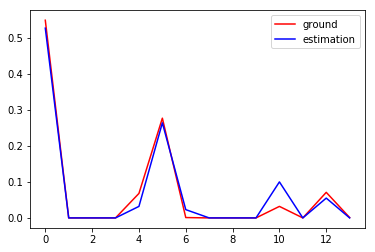

In [64]:
plt.plot(np.round(s_p[0],3),'r')
plt.plot(np.round(g_p[0],3),'b')
legend(['ground','estimation'],loc='best')
plt.show()

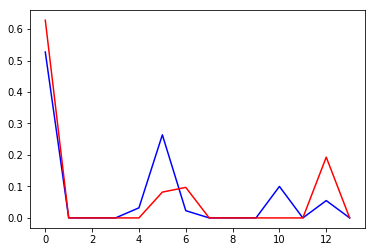

In [66]:
plt.plot(np.round(g_p[0],3),'b')
plt.plot(np.round(g_p[1],3),'r')
plt.show()